In [744]:
from commonfunctions import *
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import utlis
from sklearn import datasets, svm, metrics
import scipy
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
os.system("clear")
from skimage.transform import rescale,resize,downscale_local_mean
pytesseract.pytesseract.tesseract_cmd = r"C:\Users\ahmed\AppData\Local\Programs\Tesseract-OCR\tesseract.exe"


In [745]:
# Functions [show, scann]

def _imshow(img):
    cv2.imshow('image', img)
    plt.show()
    # specify a wait key from keyboard
    k = cv2.waitKey(0) & 0xFF

    if k == 27: #esc in keyboard
        cv2.destroyAllWindows() #close the window   

    elif k == ord('s'): #if order is s save the image
        cv2.imwrite('Test.png', img) #write image in your pc     
        cv2.destroyAllWindows() # close the window 

def _scannar(img):
    heightImg = img.shape[1]
    widthImg  = img.shape[0]
    imgBlank = np.zeros((heightImg,widthImg, 3), np.uint8) # CREATE A BLANK IMAGE FOR TESTING DEBUGING IF REQUIRED
    # imgGray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # CONVERT IMAGE TO GRAY SCALE
    imgBlur = cv2.GaussianBlur(img, (3, 3), 1) # ADD GAUSSIAN BLUR
    imgBlur = img

    imgsobel = sobel(imgBlur)
    imgThreshold = cv2.Canny(imgBlur,100,150) # APPLY CANNY BLUR
    kernel = np.ones((3, 3))
    imgDial = cv2.dilate(imgThreshold, kernel, iterations=2) # APPLY DILATION
    imgThreshold = cv2.erode(imgDial, kernel, iterations=1)  # APPLY EROSION



    ## FIND ALL COUNTOURS
    imgContours = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
    imgBigContour = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
    contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # FIND ALL CONTOURS
    cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 10) # DRAW ALL DETECTED CONTOURS
    imgThreshold = cv2.cvtColor(imgThreshold,cv2.COLOR_BAYER_BG2BGR)


    # FIND THE BIGGEST COUNTOUR
    biggest, maxArea = utlis.biggestContour(contours) # FIND THE BIGGEST CONTOUR

    if biggest.size != 0:
        biggest=utlis.reorder(biggest)
        cv2.drawContours(imgBigContour, biggest, -1, (0, 255, 0), 20) # DRAW THE BIGGEST CONTOUR
        imgBigContour = utlis.drawRectangle(imgBigContour,biggest,2)
        pts1 = np.float32(biggest) # PREPARE POINTS FOR WARP
        pts2 = np.float32([[0, 0],[widthImg, 0], [0, heightImg],[widthImg, heightImg]]) # PREPARE POINTS FOR WARP
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))

        #REMOVE 20 PIXELS FORM EACH SIDE
        imgWarpColored=imgWarpColored[:imgWarpColored.shape[0] +150, :imgWarpColored.shape[1] +150 ]

        # APPLY ADAPTIVE THRESHOLD
        # imgAdaptiveThre= cv2.adaptiveThreshold(imgWarpColored, 255, 1, 1, 7, 2)
        img = cv2.adaptiveThreshold(imgWarpColored,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,85,12)

        # imgAdaptiveThre = cv2.bitwise_not(imgAdaptiveThre)
        # imgAdaptiveThre=cv2.medianBlur(imgWarpColored,3)

    # thres = 130
    # img_bin = np.copy(imgAdaptiveThre)
    # img_bin[imgAdaptiveThre < thres] = 0
    # img_bin[imgAdaptiveThre >= thres] = 255
    # img = img_bin
    # _imshow(img)
    return img


def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)


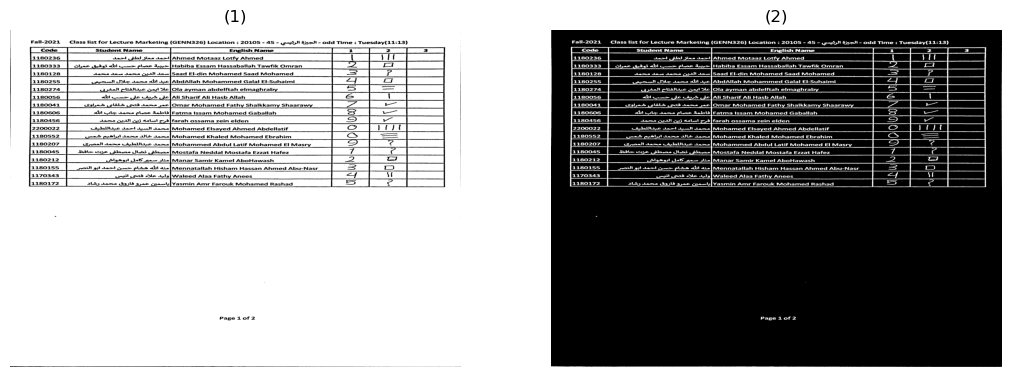

(2984, 3990)


In [746]:
######################################
# Read scan image
######################################

# read your file
file = r"E:\CUFE\Fall22\IP\Project-2022\GradesAutoFiller-main\GradesAutoFiller-main\Module1\dataSet\1.jpg"
img = cv2.imread(file,1)
## resize image if needed
# img = cv2.resize(img,None,fx = 2,fy = 2)
img = cv2.resize(img,(2984,3990))
# img = resize(img,(2984,3990))

# convert to gray scale image 
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
## applay adaptive threshold for images that have different priattness 
# img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,85,10)

# scan image 
img_sc = _scannar(img) 

# thresholding the image to a binary image
thresh, img_bin = cv2.threshold(img_sc, 200, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# inverting the image
img_sc = img_bin
img_bin = 255-img_bin

# show images
# _imshow(img)
# _imshow(img_sc)
show_images([img_sc,img_bin])
print(img_sc.shape)

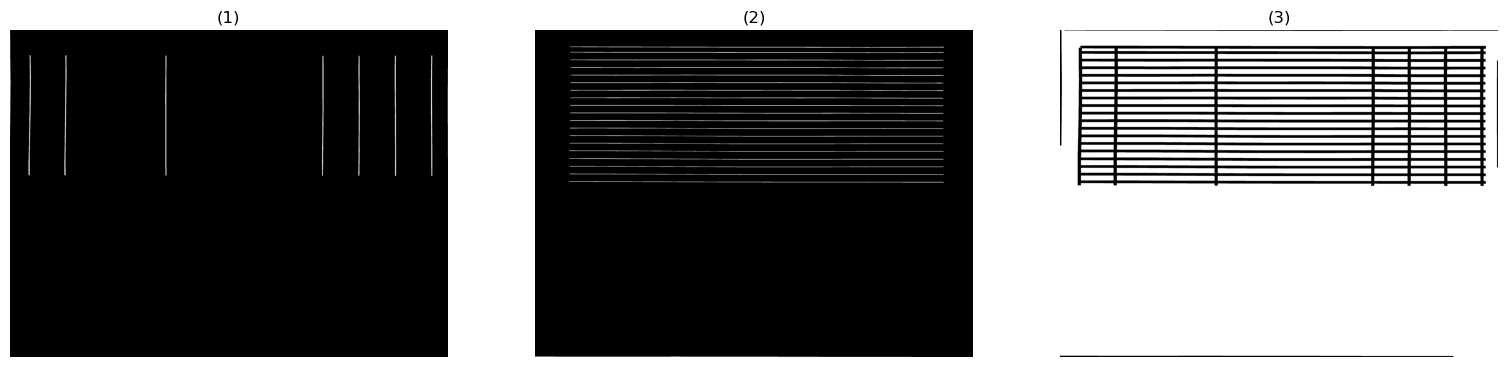

In [747]:
######################################
# Get table stracture 
######################################

# countcol(width) of kernel as 100th of total width
kernel_len = np.array(img_sc).shape[0]//360
# Defining a vertical kernel to detect all vertical lines of image
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len+8, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))

# Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=20)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=20)

# Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=18)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=18)


# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
# Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=4)
thresh, img_vh = cv2.threshold(img_vh, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# bitxor = cv2.bitwise_xor(img_sc, img_vh)
# bitnot = cv2.bitwise_not(bitxor)

# Plotting the generated image
show_images([image_1,image_2,img_vh])


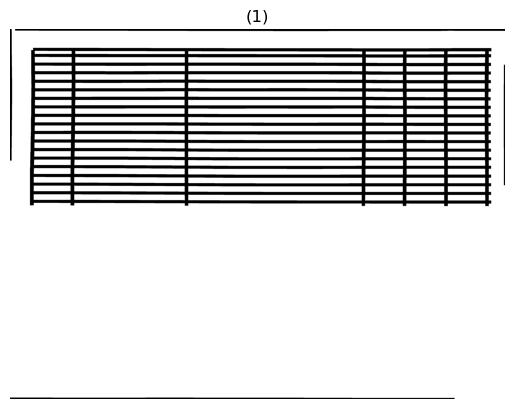

In [748]:
######################################
# Detect and sort contours
######################################

contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")
cont_img = np.copy(img_vh)
# cv2.drawContours(cont_img, contours,6, (0, 255, 0), 50)
show_images([cont_img])
cont_img = img_vh     

In [749]:
                  
#################################################################
# Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

# Get mean of heights
mean = np.mean(heights)

# Create list box to store all boxes in
box = []

# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w < 10000 and w > 200  and  h < 500):
        # image = cv2.rectangle(img_sc, (x, y), (x+w, y+h), (0, 255, 0),1)
        box.append([x, y, w, h])

# image = []
# i = 1
# image = cv2.rectangle(img_sc, (box[i][0], box[i][1]), (box[i][0]+box[i][2], box[i][1]+box[i][3]), (0, 255, 0),50)
# show_images([image])
# print(box[5])
#############################################################################


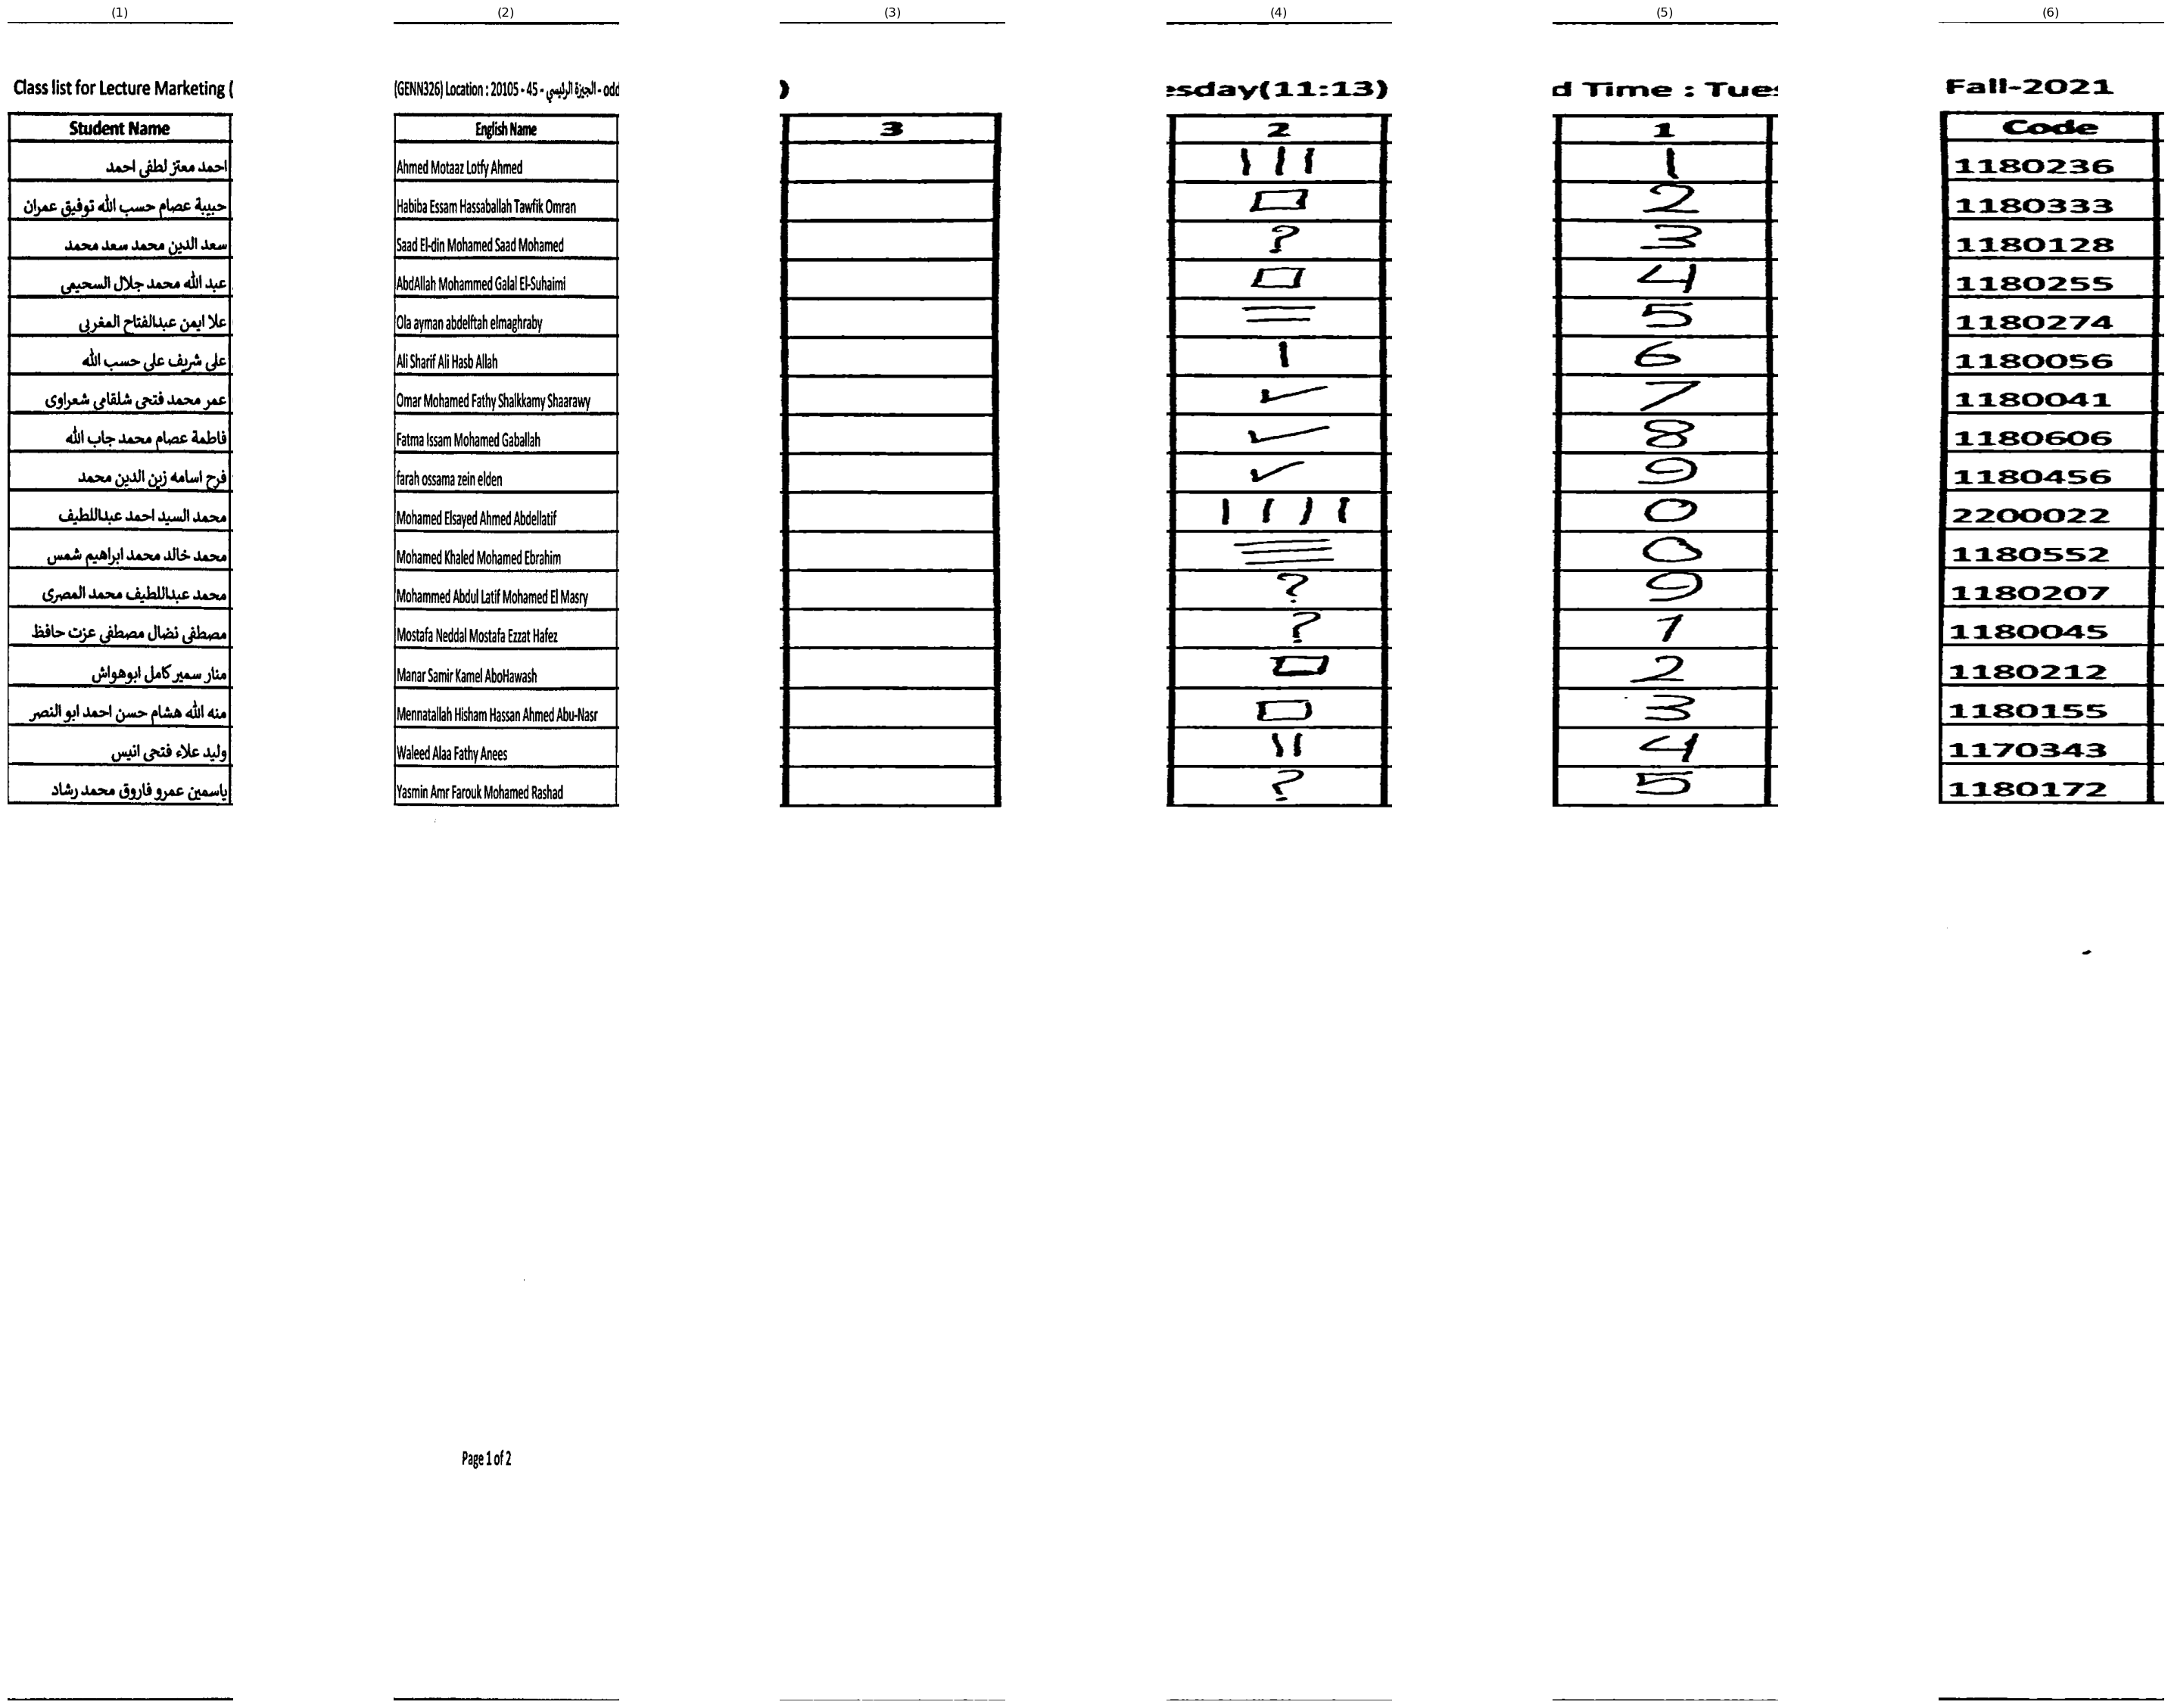

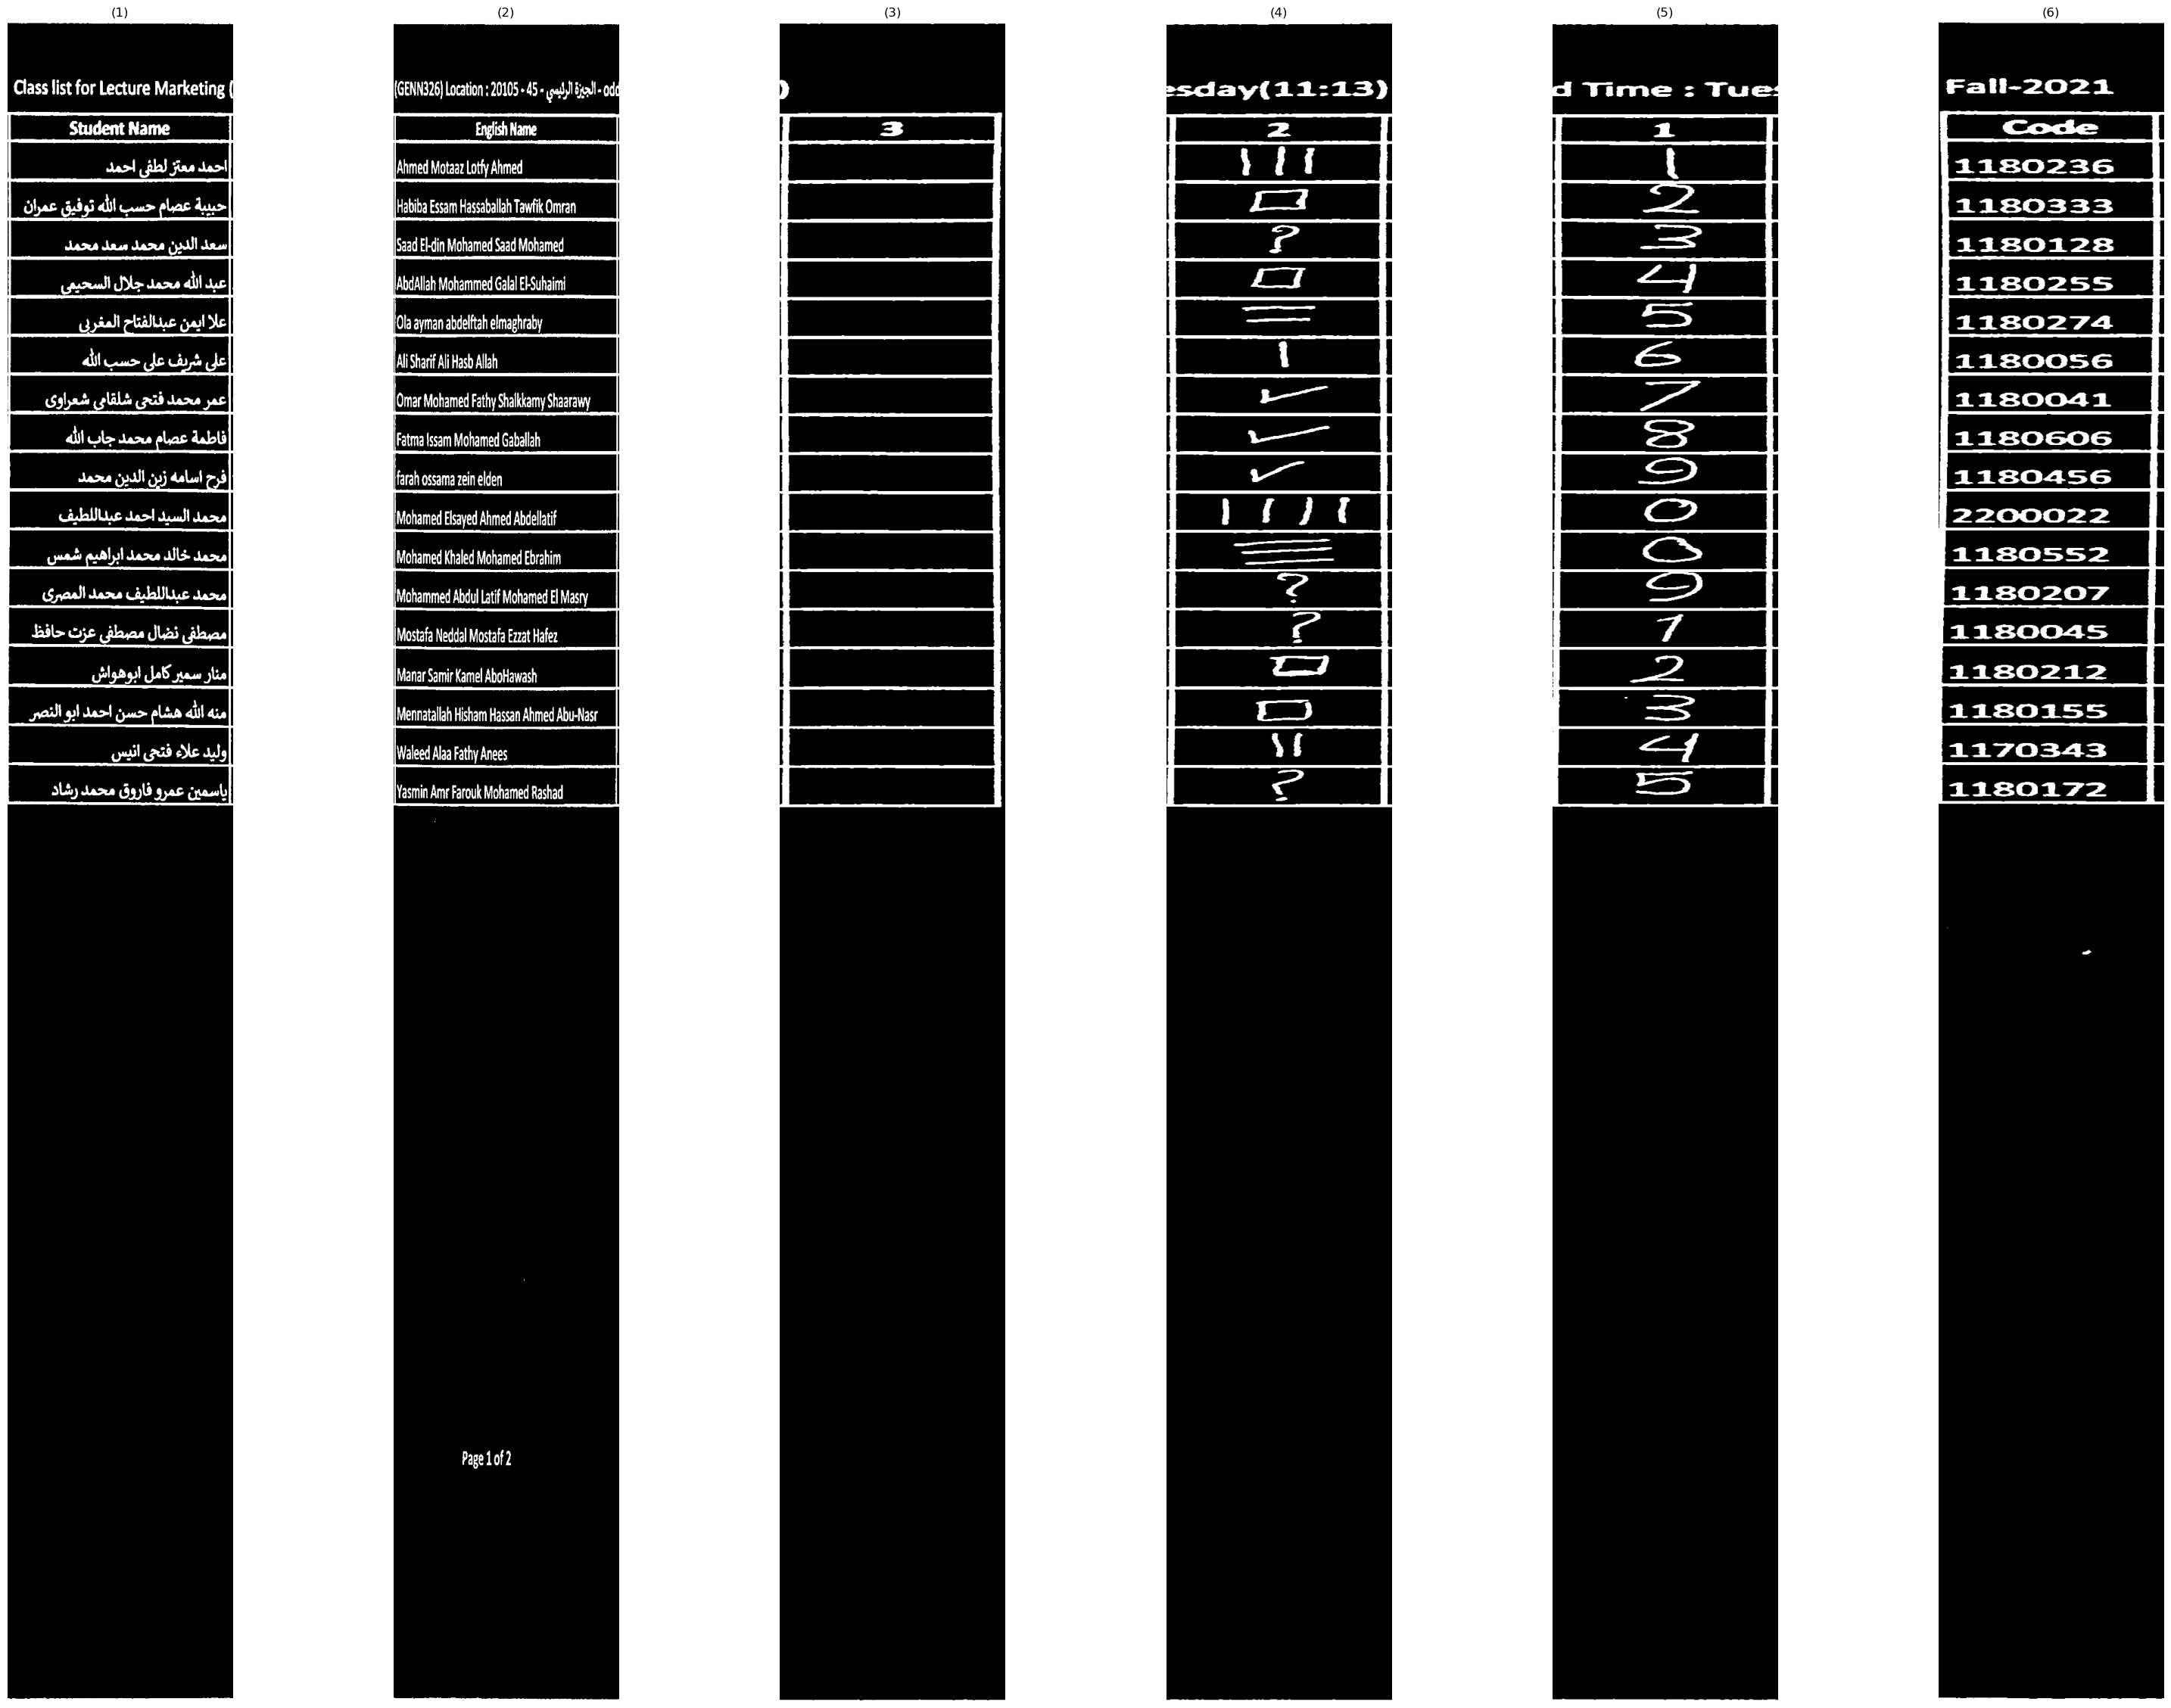

In [750]:

######################################
# Convert image into colunms 
######################################
mr = 25
ml = 25
cols = []
col = 0
for i in range(1,7):
    col = img_sc[:,box[i][0]-ml:box[i][0]+box[i][2]+mr]
    cols.append(col)
    # print(col.shape)

# show_images([cols[0],cols[1],cols[2],cols[3],cols[4],cols[5]])

for i in range(len(cols)):
    cols[i] = cv2.resize(cols[i],(400,img_sc.shape[0]))

ncols = np.zeros((len(cols),img_sc.shape[0],400))
for i in range(len(cols)):
    ncols[i] = 255 - cols[i]

show_images([cols[0],cols[1],cols[2],cols[3],cols[4],cols[5]])
show_images([ncols[0],ncols[1],ncols[2],ncols[3],ncols[4],ncols[5]])
###############################################################    


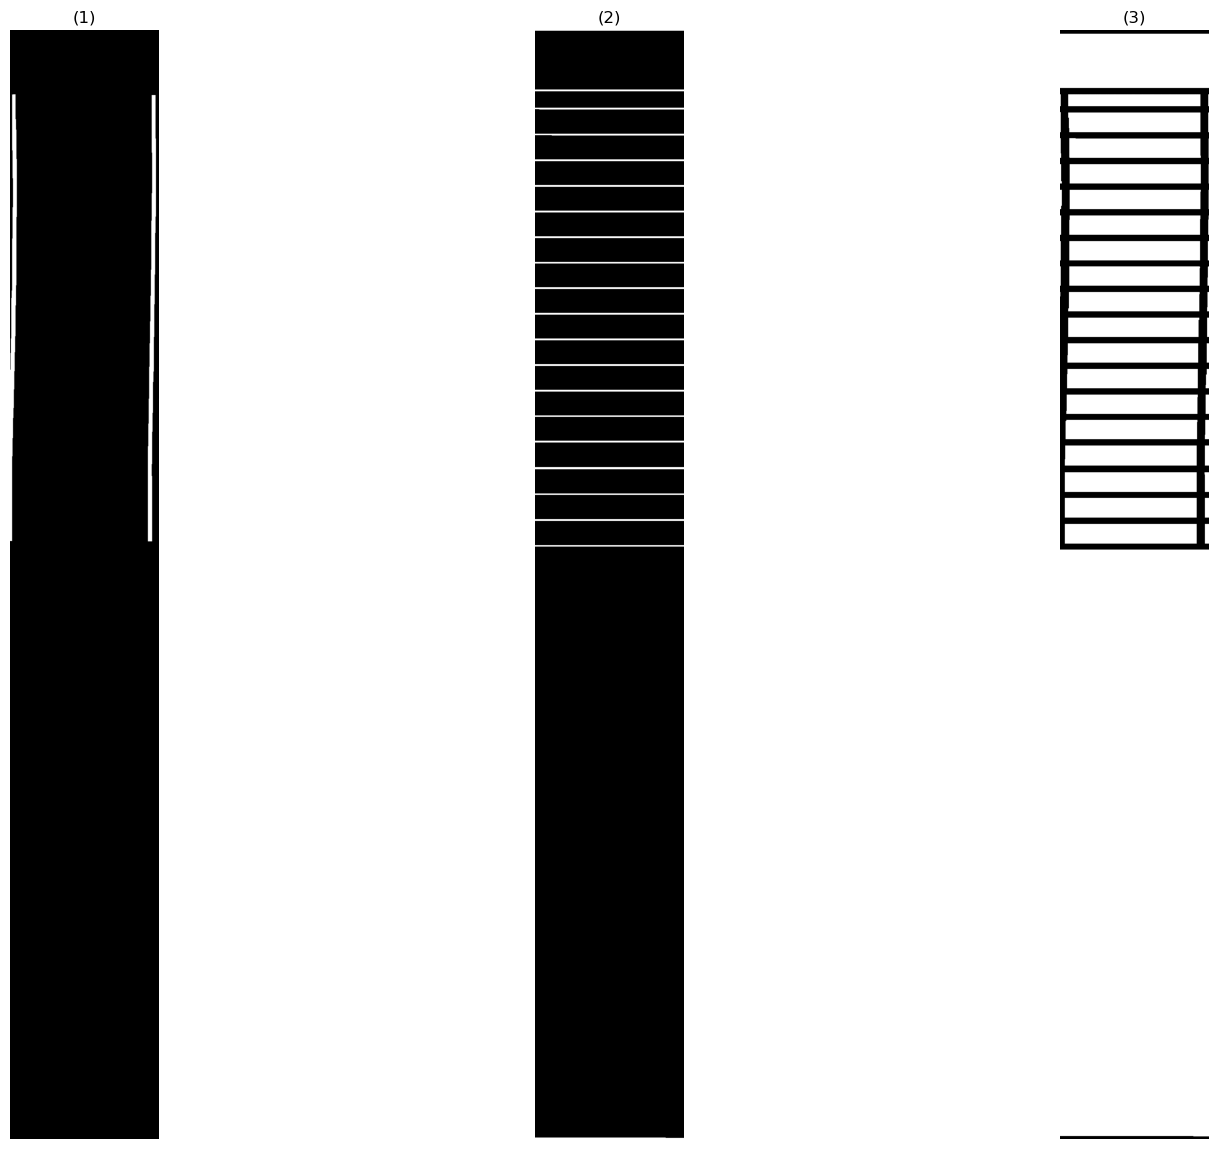

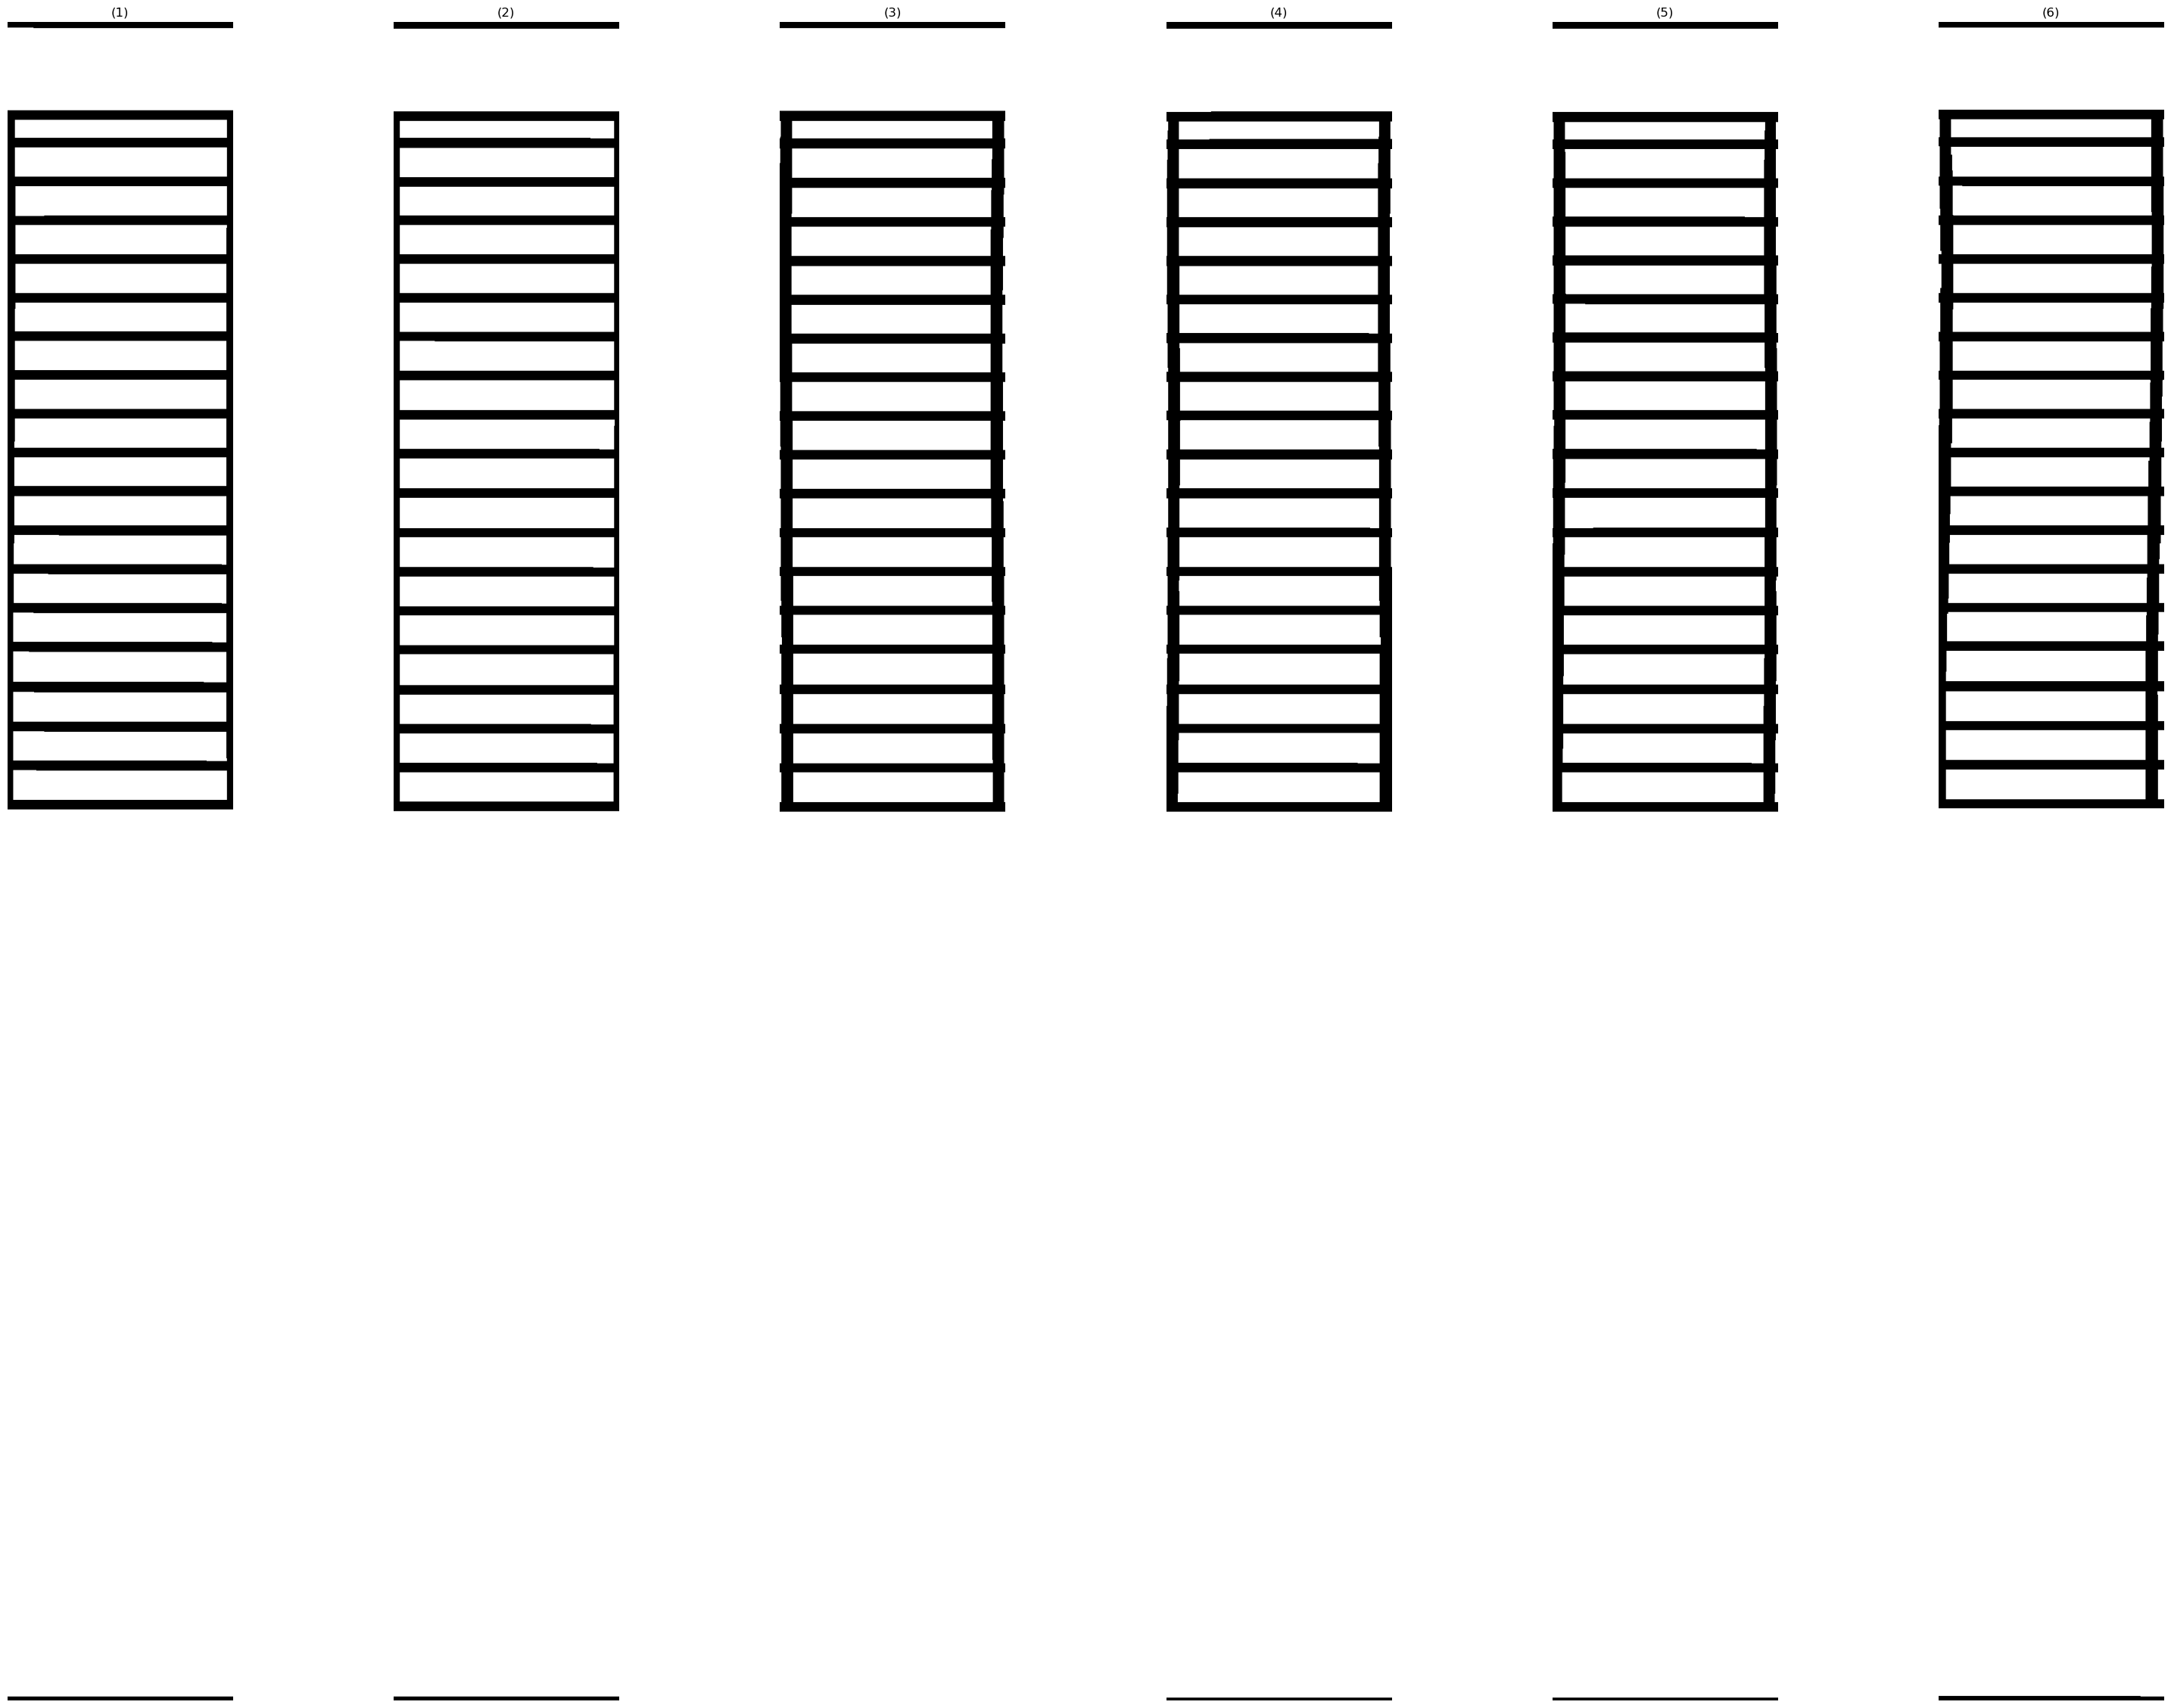

In [704]:
# 1st col  
######################################
i = 0
img_vh_cols = np.zeros((len(cols),img_sc.shape[0],400),np.uint8)
for i in range(len(cols)):
    tcol = cols[i]
    ncol = ncols[i]
    # countcol(width) of kernel as 100th of total width
    kernel_len_col1  = np.array(tcol).shape[1]//150
    # Defining a vertical kernel to detect all vertical lines of image
    ver_kernel_col1  = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len_col1+5 ))
    # Defining a horizontal kernel to detect all horizontal lines of image
    hor_kernel_col1  = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len_col1 +20, 1))
    # A kernel of 2x2
    kernel_col1  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))

    # Use vertical kernel to detect and save the vertical lines in a jpg
    image_1_col1  = cv2.erode(ncol, ver_kernel_col1 , iterations=25)
    vertical_lines_col1  = cv2.dilate(image_1_col1, ver_kernel_col1 , iterations=20)

    # Use horizontal kernel to detect and save the horizontal lines in a jpg
    image_2_col1  = cv2.erode(ncol, hor_kernel, iterations=20)
    horizontal_lines_col1  = cv2.dilate(image_2_col1, hor_kernel_col1 , iterations=30)


    # Combine horizontal and vertical lines in a new third image, with both having same weight.
    # img_vh_col = img_vh_cols[i]
    img_vh_cols[i] = cv2.addWeighted(vertical_lines_col1 , 0.5, horizontal_lines_col1 , 0.5, 0.0)
    # Eroding and thesholding the image
    img_vh_cols[i]= cv2.erode((255 - img_vh_cols[i]) , kernel_col1 , iterations=4)
    _, img_vh_cols[i] = cv2.threshold(img_vh_cols[i] , 128, 255, cv2.THRESH_BINARY )
    # bitxor = cv2.bitwise_xor(img_sc, img_vh)
    # bitnot = cv2.bitwise_not(bitxor)
    if (i == 5):
        show_images([vertical_lines_col1,horizontal_lines_col1,img_vh_cols[i] ])

    # Plotting the generated image
    # print(f"****{i}****")
show_images([img_vh_cols[0],img_vh_cols[1],img_vh_cols[2],img_vh_cols[3],img_vh_cols[4],img_vh_cols[5] ])
    

#######################################################################################


In [705]:
### Detect and sort contours
######################################
contours_cols = []
for i in range(len(cols)):
    contours_col, hierarchy_col = cv2.findContours(img_vh_cols[i], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_cols.append(contours_col)


In [677]:

# i = 5
# cont_img = np.copy(cols[i])
# cv2.drawContours(cont_img, contours_cols[i],-1, (0, 255, 0), 9)
# show_images([cont_img])
# cont_img = img_vh

In [707]:

# Sort all the contours by top to bottom.
boundingBoxes = []
for i in range(len(cols)-1):
    contours_cols[i], boundingBoxes1 = sort_contours(contours_cols[0], method="top-to-bottom")
    boundingBoxes.append(boundingBoxes1)

# Creating a list of heights for all detected boxes
heights = []
means = []

for k in range(len(boundingBoxes)):
    height = [boundingBoxes[k][i][3] for i in range(len(boundingBoxes[k][i]))]
    heights.append(height)
    # Get mean of heights
    mean = np.mean(height)
    means.append(mean)

# Create list box to store all boxes in
##########################################
box = []
boxs = []
i = 5 
# Get position (x,y), width and height for every contour and show the contour on image
for i in range(len(contours_cols)):  
    box = []
    for c in contours_cols[i]:
        x, y, w, h = cv2.boundingRect(c)
        if (w < 10000 and w > 200  and  h < 500):
            # image = cv2.rectangle(cols[i], (x, y), (x+w, y+h), (0, 255, 0),9)
            box.append([x, y, w, h])
    boxs.append(box)
# show_images([image])

# print(boxs[0])

In [737]:
###########################################################################
col_cells = []
cols_cells = []
m = 10
# for j in range(len(contours_cols)):
j = 5
k = 0
for j in range(len(boxs)):
    col_cells = []
    k = j
    for i in range(len(boxs[j])):
        img3 = cols[j][boxs[k][i][1]-m:boxs[k][i][1]+boxs[k][i][3],boxs[k][i][0]-m:boxs[k][i][0]+boxs[k][i][2]]
        col_cells.append(img3)
    cols_cells.append(col_cells)
    

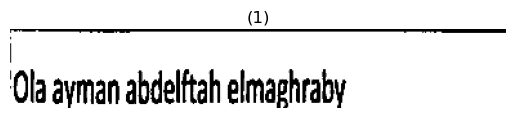

In [738]:
show_images([cols_cells[1][6]])


In [740]:

# cols_cells.append(col_cells)
j = 1
# for k in range(1,len(cols_cells[j])):
#     io.imsave(f'img3_c{j}_{k}.jpeg',cols_cells[j][k])

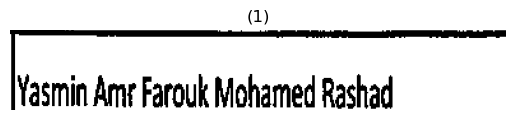

Yasmin Ame Farouk Mohamed Rashad



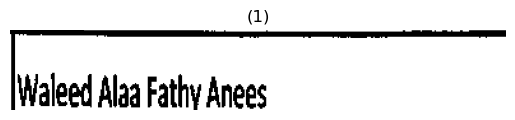

Waleed Alaa Fathy Anees



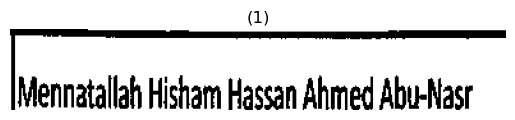

Mennatallah Hisham Hassan Ahmed Abu-Nasr



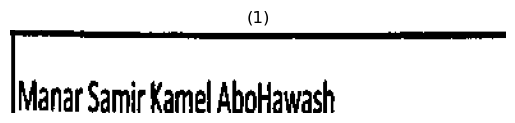

Manar Samir Kamel AboHawach



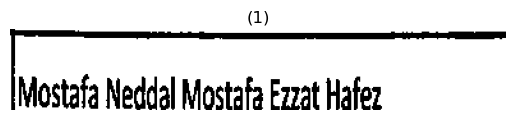

Mostafa Neddal Mostafa Fzzat Hafoz



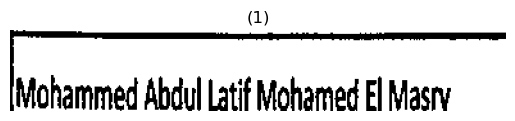

Mohammed Abdul Latif Mohamed F] Masry:



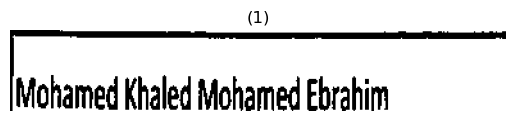

Mohamed Khaled Mohamed Fbrahin



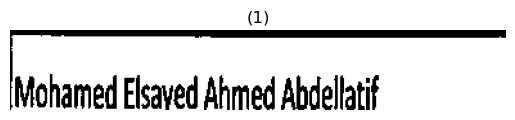

Mohamed Elsaved Ahmed Abdollatif



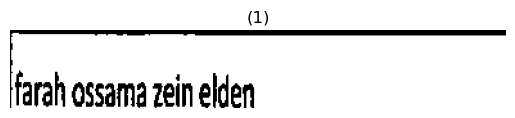

farah ossama zein elden



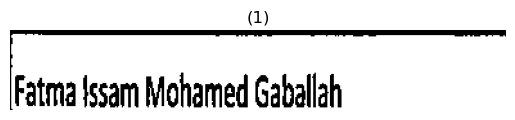

Fatma ‘ssam Mohamed Gaballah



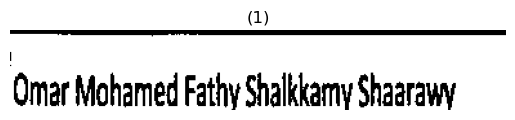

Omar Mohamed Fathy Shalkkamy Shaarawy



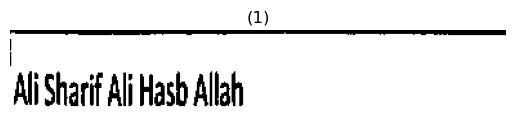

Ali Sharif Ali Hasb Aah



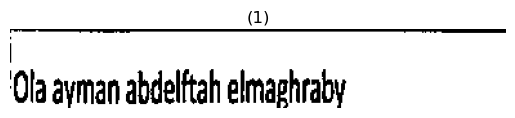

Cla ayman abdelftah elmaahraby



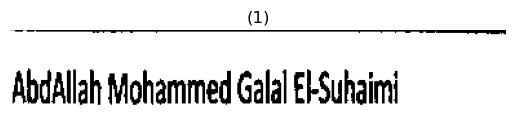

Abdallah Mohammed Galal E-Suhaimi



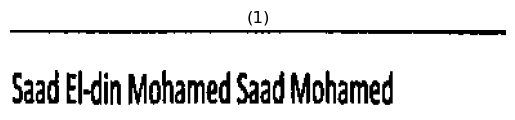

Saad El-din Mohamed Saad Mohamed



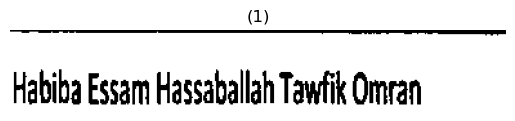

Habiba Essam Hassaballah Tawfik Omran



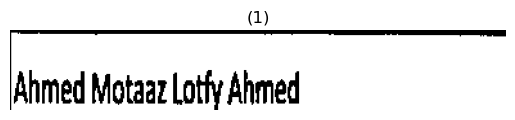

Ahmed Motaaz Lotfy Ahmed



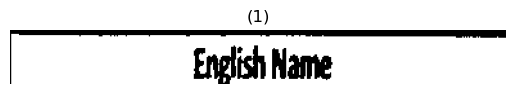

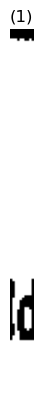

In [741]:
cell_text = []
for i in range (len(cols_cells[j])-1,-1,-1):
    img5 = cols_cells[j][i]
    _, cols_cells[j][i] = cv2.threshold(img5,150,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    show_images([cols_cells[j][i]])
    cell_texts = pytesseract.image_to_string(cols_cells[j][i], config = "8")
    cell_text.append(cell_texts)
    print(cell_texts)
    

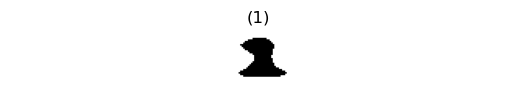

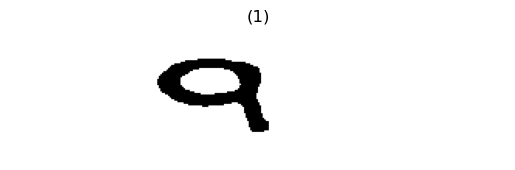

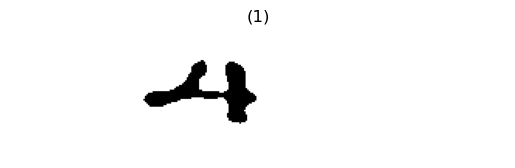

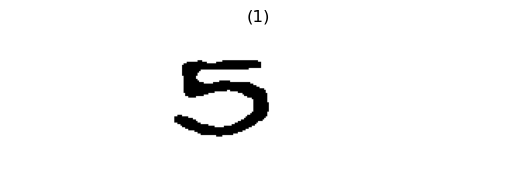

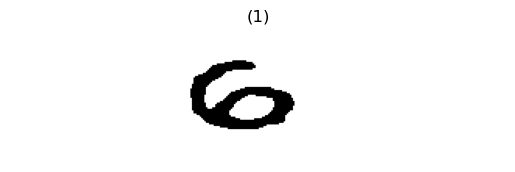

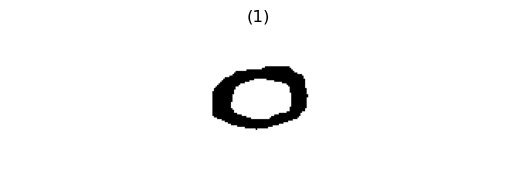

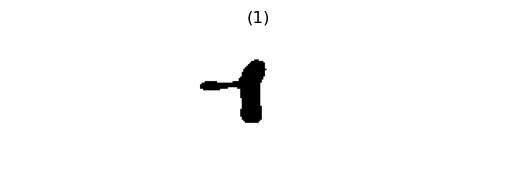

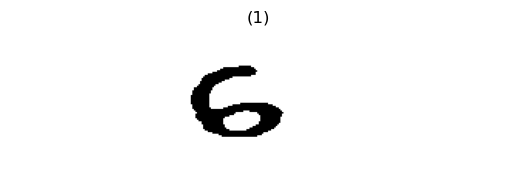

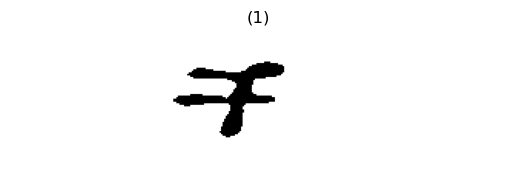

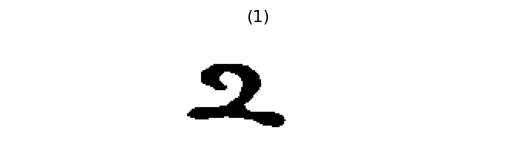

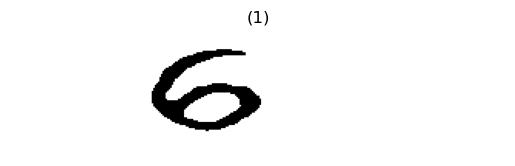

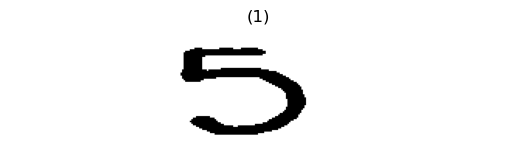

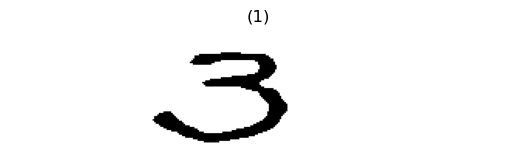

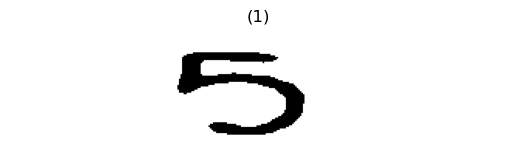

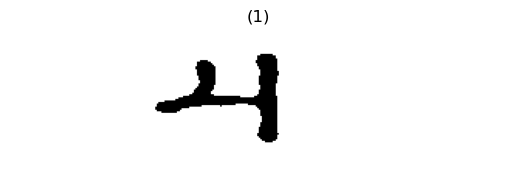

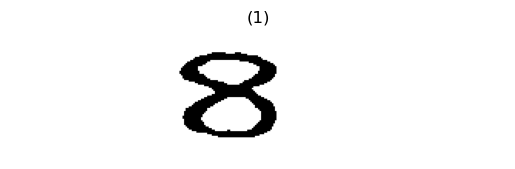

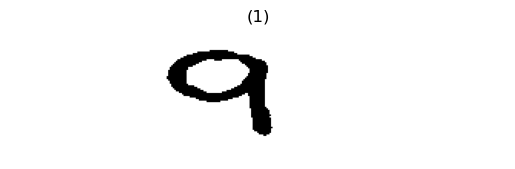

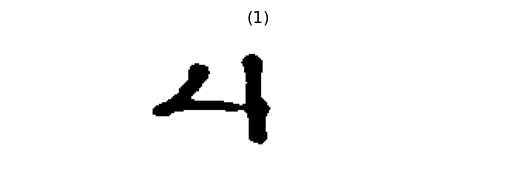

In [60]:

# _, cells_img[0] = cv2.threshold(cells_img[0],70,255,cv2.THRESH_BINARY)
# # celltext = pytesseract.image_to_string(cells_img[0])
# # cell_list.append(celltext)
# # show_images([cells_img[0]])
# # print(celltext)

  

# for i in range(1,len(cells_img)):
#     _, cells_img[i] = cv2.threshold(cells_img[i],90,255,cv2.THRESH_BINARY)
#     celltext = pytesseract.image_to_string(cells_img[i])
#     cell_list.append(celltext)
#     show_images([cells_img[i]])
#     print(celltext)



In [ ]:

# finalboxes = []
# for i in range(len(row)):
#     lis = []
#     for k in range(countcol):
#         lis.append([])
#     for j in range(len(row[i])):
#         diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
#         minimum = min(diff)
#         indexing = list(diff).index(minimum)
#         lis[indexing].append(row[i][j])
#     finalboxes.append(lis)

# # finalboxes = box
# # print(finalboxes)
# # print(box)
# print(finalboxes[0])
# print(box[1])

In [742]:
################Excel###################

arr = np.array(cell_text)
dataframe = pd.DataFrame(arr)
print(dataframe)
data = dataframe.style.set_properties(align="left")
# Converting it in a excel-file
data.to_excel("E:\CUFE\Fall22\IP\Project-2022\GradesAutoFiller-main\GradesAutoFiller-main\Module1\output.xlsx",index=None,header="code")


                                             0
0           Yasmin Ame Farouk Mohamed Rashad\n
1                    Waleed Alaa Fathy Anees\n
2   Mennatallah Hisham Hassan Ahmed Abu-Nasr\n
3                Manar Samir Kamel AboHawach\n
4         Mostafa Neddal Mostafa Fzzat Hafoz\n
5     Mohammed Abdul Latif Mohamed F] Masry:\n
6             Mohamed Khaled Mohamed Fbrahin\n
7           Mohamed Elsaved Ahmed Abdollatif\n
8                    farah ossama zein elden\n
9               Fatma ‘ssam Mohamed Gaballah\n
10     Omar Mohamed Fathy Shalkkamy Shaarawy\n
11                   Ali Sharif Ali Hasb Aah\n
12            Cla ayman abdelftah elmaahraby\n
13         Abdallah Mohammed Galal E-Suhaimi\n
14          Saad El-din Mohamed Saad Mohamed\n
15     Habiba Essam Hassaballah Tawfik Omran\n
16                  Ahmed Motaaz Lotfy Ahmed\n
17                                            
18                                            


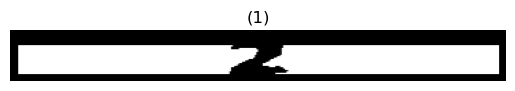

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/testing'

In [424]:
############# ML ####################
# save cells:
img6 = cells_img[1]
show_images([img6])

directory = '/testing'
output_directory = '/testing'

PRINT_SLICES = False
THRESHOLD_PIXELS_COUNT = 60000
MAX_BOUNDING_BOX_WIDTH = 675
MAX_BOUNDING_BOX_HEIGHT = 50

def detect_left_edge(image):
    h,w = image.shape
    max = 0
    edge = 0
    for x in range(0,100):

        vertical_slice = image[0:h,  x:x+15 ]
        vertical_slice_pixels_count = vertical_slice.sum()

        if( vertical_slice_pixels_count > THRESHOLD_PIXELS_COUNT):
            scipy.misc.imsave(output_directory + '/' + filename, image[0:h, x:675])
            return 0

        if (vertical_slice_pixels_count > max):
            max = vertical_slice_pixels_count
            edge = x * 2
    return edge

# loop over images
for filename in os.listdir(directory):
    if filename.endswith("negate.jpg"):
        input_image = scipy.misc.imread(directory + '/' + filename)
        image_height, image_width = input_image.shape
        max = 0;
        output_image = input_image
        # detect top edge of the image bounding box
        for h in range(0, image_height - MAX_BOUNDING_BOX_HEIGHT):
            temp_image = input_image[h:h + MAX_BOUNDING_BOX_HEIGHT, 0:0 + MAX_BOUNDING_BOX_WIDTH]
            if temp_image.sum() > max:
                max= temp_image.sum()
                output_image = temp_image
        edge = detect_left_edge(output_image)

In [ ]:
#symbols dataset
def Readcheck(directory):
    fnames = os.listdir(directory)
    check = []
    for fn in fnames:
        path = os.path.join(directory, fn)
        gray_scale_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        check.append(gray_scale_image)

    return check

def ReadQ(directory):
    fnames = os.listdir(directory)
    Q = []
    for fn in fnames:
        path = os.path.join(directory, fn)
        gray_scale_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        Q.append(gray_scale_image)

    return Q

def ReadEmpty(directory):
    fnames = os.listdir(directory)
    empty = []
    for fn in fnames:
        path = os.path.join(directory, fn)
        gray_scale_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        empty.append(gray_scale_image)

    return empty

def ReadSquare(directory):
    fnames = os.listdir(directory)
    square = []
    for fn in fnames:
        path = os.path.join(directory, fn)
        gray_scale_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        square.append(gray_scale_image)

    return square

def Readver1(directory):
    fnames = os.listdir(directory)
    ver1 = []
    for fn in fnames:
        path = os.path.join(directory, fn)
        gray_scale_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        ver1.append(gray_scale_image)

    return ver1

def Readver2(directory):
    fnames = os.listdir(directory)
    ver2 = []
    for fn in fnames:
        path = os.path.join(directory, fn)
        gray_scale_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        ver2.append(gray_scale_image)

    return ver2

def Readver3(directory):
    fnames = os.listdir(directory)
    ver3 = []
    for fn in fnames:
        path = os.path.join(directory, fn)
        gray_scale_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        ver3.append(gray_scale_image)

    return ver3

def Readver4(directory):
    fnames = os.listdir(directory)
    ver4 = []
    for fn in fnames:
        path = os.path.join(directory, fn)
        gray_scale_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        ver4.append(gray_scale_image)

    return ver4

def Readver5(directory):
    fnames = os.listdir(directory)
    ver5 = []
    for fn in fnames:
        path = os.path.join(directory, fn)
        gray_scale_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        ver5.append(gray_scale_image)

    return ver5

def Readdash(directory):
    fnames = os.listdir(directory)
    dash = []
    for fn in fnames:
        path = os.path.join(directory, fn)
        gray_scale_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        dash.append(gray_scale_image)

    return dash

def Readhor2(directory):
    fnames = os.listdir(directory)
    hor2 = []
    for fn in fnames:
        path = os.path.join(directory, fn)
        gray_scale_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        hor2.append(gray_scale_image)

    return hor2

def Readhor3(directory):
    fnames = os.listdir(directory)
    hor3 = []
    for fn in fnames:
        path = os.path.join(directory, fn)
        gray_scale_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        hor3.append(gray_scale_image)

    return hor3

def Readhor4(directory):
    fnames = os.listdir(directory)
    hor4 = []
    for fn in fnames:
        path = os.path.join(directory, fn)
        gray_scale_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        hor4.append(gray_scale_image)

    return hor4

check= []
Q=[]
square= []
empty = []
dash=[]
hor2 = []
hor3 =[]
hor4 = []
ver1=[]
ver2=[]
ver3=[]
ver4=[]
ver5=[]

check= Readcheck(r"D:\Farah\college\Image processing\module1\cells\check")
Q = ReadQ(r"D:\Farah\college\Image processing\module1\cells\q")
square = ReadSquare(r"D:\Farah\college\Image processing\module1\cells\square")
empty = ReadEmpty(r"D:\Farah\college\Image processing\module1\cells\empty")
dash = Readdash(r"D:\Farah\college\Image processing\module1\cells\dash")
hor2= Readhor2(r"D:\Farah\college\Image processing\module1\cells\hor2")
hor3 = Readhor3(r"D:\Farah\college\Image processing\module1\cells\hor3")
hor4 = Readhor4(r"D:\Farah\college\Image processing\module1\cells\hor4")
ver1 = Readver1(r"D:\Farah\college\Image processing\module1\cells\ver1")
ver2 = Readver2(r"D:\Farah\college\Image processing\module1\cells\ver2")
ver3 = Readver3(r"D:\Farah\college\Image processing\module1\cells\ver3")
ver4 = Readver4(r"D:\Farah\college\Image processing\module1\cells\ver4")
ver5 = Readver5(r"D:\Farah\college\Image processing\module1\cells\ver5")

#Handwritten digits classifier


DIGIT_WIDTH = 10
DIGIT_HEIGHT = 20
IMG_HEIGHT = 28
IMG_WIDTH = 28
CLASS_N = 10 

class KNN_MODEL():
    def _init_(self, k=3):
        self.k = k
        self.model = cv2.ml.KNearest_create()

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        retval, results, neigh_resp, dists = self.model.findNearest(samples, self.k)
        return results.ravel()
class SVM_MODEL():
    def _init_(self, num_feats, C=1, gamma=0.1):
        self.model = cv2.ml.SVM_create()
        self.model.setType(cv2.ml.SVM_C_SVC)
        self.model.setKernel(cv2.ml.SVM_RBF)  # SVM_LINEAR, SVM_RBF
        self.model.setC(C)
        self.model.setGamma(gamma)
        self.features = num_feats

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        results = self.model.predict(samples.reshape(-1, self.features))
        return results[1].ravel()
    
def pixels_to_hog_20(img_array):
    hog_featuresData = []
    for img in img_array:
        fd = hog(img,orientations=10,pixels_per_cell=(5, 5),cells_per_block=(1, 1),Visualise=False)
        hog_featuresData.append(fd)
    hog_features = np.array(hog_featuresData, 'float64')
    return np.float32(hog_features)

def get_contour_precedence(contour, cols):
    return contour[1] * cols + contour[0]  # row-wise ordering


def get_digits(contours, hierarchy):
    hierarchy = hierarchy[0]
    bounding_rectangles = [cv2.boundingRect(ctr) for ctr in contours]
    final_bounding_rectangles = []
    # find the most common heirarchy level - that is where our digits's bounding boxes are
    u, indices = np.unique(hierarchy[:, -1], return_inverse=True)
    most_common_heirarchy = u[np.argmax(np.bincount(indices))]

    for r, hr in zip(bounding_rectangles, hierarchy):
        x, y, w, h = r
        # this could vary depending on the image you are trying to predict
        # we are trying to extract ONLY the rectangles with images in it (this is a very simple way to do it)
        # we use heirarchy to extract only the boxes that are in the same global level - to avoid digits inside other digits
        # ex: there could be a bounding box inside every 6,9,8 because of the loops in the number's appearence - we don't want that.
        # read more about it here: https://docs.opencv.org/trunk/d9/d8b/tutorial_py_contours_hierarchy.html
        if ((w * h) > 250) and (10 <= w <= 200) and (10 <= h <= 200) and hr[3] == most_common_heirarchy:
            final_bounding_rectangles.append(r)

    return final_bounding_rectangles

def load_digits_custom(img_file, ):
    train_data = []
    # pd.read_csv('train.csv')
    # train_data=
    train_target = []
    start_class = 1
    im = cv2.imread(img_file)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    # plt.imshow(imgray)
    kernel = np.ones((5, 5), np.uint8)

    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    digits_rectangles = get_digits(contours, hierarchy)  # rectangles of bounding the digits in user image

    # sort rectangles accoring to x,y pos so that we can label them
    digits_rectangles.sort(key=lambda x: get_contour_precedence(x, im.shape[1]))

    for index, rect in enumerate(digits_rectangles):
        x, y, w, h = rect
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
        im_digit = imgray[y:y + h, x:x + w]
        im_digit = (255 - im_digit)

        im_digit = cv2.resize(im_digit, (IMG_WIDTH, IMG_HEIGHT))
        train_data.append(im_digit)
        train_target.append(start_class % 10)

        if index > 0 and (index + 1) % 10 == 0:
            start_class += 1
    cv2.imwrite("training_box_overlay.png", im)

    return np.array(train_data), np.array(train_target)

def Num_Classifier(img_test):
    TRAIN_MNIST_IMG = 'digits.png'
    TRAIN_USER_IMG = 'custom_train_digits.jpg'
    TEST_USER_IMG = img_test
    # digits, labels = load_digits(TRAIN_MNIST_IMG) #original MNIST data (not good detection)
    digits, labels = load_digits_custom(TRAIN_USER_IMG)  # my handwritten dataset (better than MNIST on my handwritten digits)

    print('train data shape', digits.shape)
    print('test data shape', labels.shape)

    digits, labels = shuffle(digits, labels, random_state=256)
    train_digits_data = pixels_to_hog_20(digits)
    X_train, X_test, y_train, y_test = train_test_split(train_digits_data, labels, test_size=0.33, random_state=42)

    # ------------------training and testing----------------------------------------

    model = KNN_MODEL(k=7)
    model.train(X_train, y_train)
    preds = model.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, preds))

    model = KNN_MODEL(k=7)
    model.train(train_digits_data, labels)
    numbers = proc_user_img(TEST_USER_IMG, model)

    model = SVM_MODEL(num_feats=train_digits_data.shape[1])
    model.train(X_train, y_train)
    preds = model.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, preds))

    model = SVM_MODEL(num_feats=train_digits_data.shape[1])
    model.train(train_digits_data, labels)
    proc_user_img(TEST_USER_IMG, model)
    w = ""
    for i in reversed(numbers):
        w += i + ""

    return w

In [ ]:

# # calculating maximum number of cells
# countcol = 0
# for i in range(len(row)):
#     countcol = len(row[i])
#     if countcol > countcol:
#         countcol = countcol

# # Retrieving the center of each column
# center = [int(row[i][j][0]+row[i][j][2]/2)
#           for j in range(len(row[i])) if row[0]]

# center = np.array(center)
# print(len(center))
# center.sort()
# print(center)
# # Regarding the distance to the columns center, the boxes are arranged in respective order
# img5 = img[:,:252]
# show_images([img5])

In [ ]:

# # Creating two lists to define row and column in which cell is located
# row = []
# column = []
# j = 0

# # Sorting the boxes to their respective row and column
# for i in range(len(box)):
#     if(i == 0):
#         column.append(box[i])
#         previous = box[i]
#     else:
#         if(box[i][1] <= previous[1]+mean/2):
#             column.append(box[i])
#             previous = box[i]

#             if(i == len(box)-1):
#                 row.append(column)
#         else:
#             row.append(column)
#             column = []
#             previous = box[i]
#             column.append(box[i])
# print(column[0][0])
# print(row)
# print(box)
# # img4 = img[column[0][2]:column[0][3],column[0][0]:column[0][1]]
